In [40]:
import os, re, string, csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dateutil
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import  RegexpTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from dateutil.parser import parse
from glob import glob

plt.style.use('seaborn')

In [42]:
#Leitura do arquivo
#data = pd.read_csv('data_set.csv')
data = pd.read_csv('out_dataset_interests.csv')
'''
#Correção no formato da data
data['created_at'] = data['created_at'].apply(dateutil.parser.parse, dayfirst = True)
#Remove as horas da coluna created_at, apenas em tempo de execução
data['created_at'] = data['created_at'].dt.strftime('%Y-%m-%d')
'''
data.head()

,date,id_str,user_name,text,time,latitude,longitude,interest
0,2018-05-03,1.291239e+09,1fsmith1,blessed home hawai ’ weeks kanaka kav,01:25:05,19.634691,-155.989839,True
1,2018-05-06,1.720077e+09,808Plate,feliz cinco mayo ohana 🤙 🏽 plate 📍 pint amp co...,03:27:32,20.687110,-156.440300,True
2,2018-05-01,1.197860e+08,AdamBuzz,riley absolutely loved beach showed fear waves...,23:51:32,19.827920,-155.991320,True
3,2018-05-06,1.575202e+09,AirHawaiiNet,キラウエア火山の噴火 🌋 近隣の方々は大丈夫かな … 大自然と共存してる以上 、 仕方のない...,06:18:52,19.618380,-155.985540,True
4,2018-05-05,1.947484e+09,AlainaFuata,“ she pele honua mea pele sacred land she pele...,04:29:08,19.473500,-154.920000,True


In [43]:
#Quantidade de linhas do dataset
#data['created_at'].count()
data['date'].count()

373

In [17]:
#Data mais antiga
#data['created_at'].min()
data['date'].min()

'2018-04-29'

In [18]:
#Data mais recente
#data['created_at'].max()
data['date'].max()

'2018-05-28'

In [19]:
#keys  = data['created_at'].unique()
keys  = data['date'].unique()
len(keys)
#Corresponde ao total de datas unicas, pra ajudar nos agrupamentos 

20

In [20]:
#AgrupamentosS
#qkeys = data['created_at'].value_counts()
qkeys = data['date'].value_counts()
qkeys

2018-05-04    39
2018-05-05    37
2018-05-02    32
2018-05-06    32
2018-05-25    32
2018-05-01    30
2018-05-08    27
2018-05-07    25
2018-05-28    24
2018-05-03    21
2018-05-09    13
2018-04-30    12
2018-05-26     9
2018-05-27     8
2018-05-24     7
2018-05-22     7
2018-05-20     5
2018-05-21     5
2018-05-23     4
2018-04-29     4
Name: date, dtype: int64

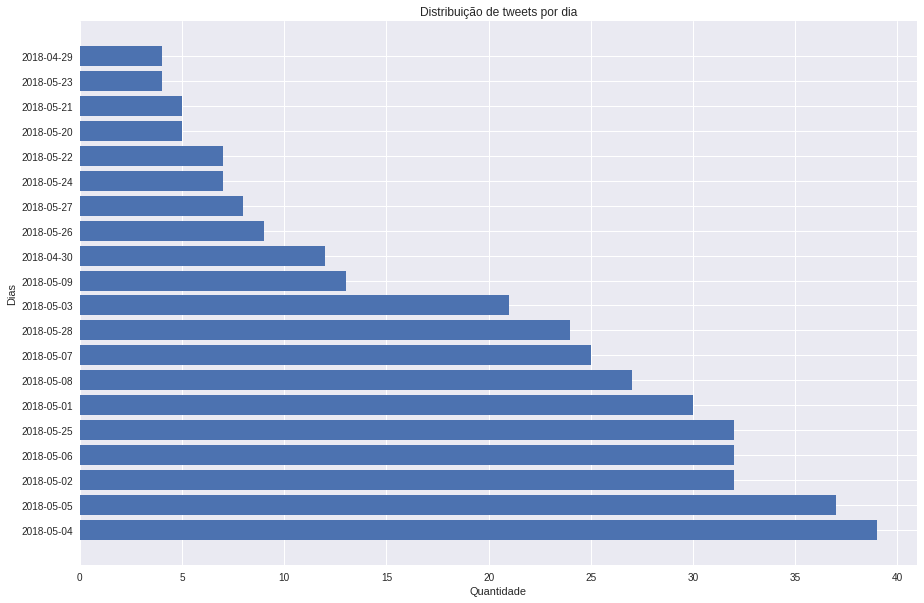

In [23]:
#Plot da distribuição dos tweets por dia -> Ok

#tkeys = data.groupby('created_at').count()
tkeys = data.groupby('date').count()


obj = dict(qkeys)

posix = np.arange(len(obj.keys()))
plt.figure(figsize = (15, 10))
plt.barh(posix, list(obj.values()), align = 'center')
plt.yticks(posix, obj.keys())

plt.xlabel('Quantidade')
plt.ylabel('Dias')
plt.title('Distribuição de tweets por dia')
 
plt.show()


In [26]:

#Agrpamento por dia... Tweets agrupados e separados em arquivos com as datas correspondentes
# -> Ok
for find in keys:
    out = csv.writer(open("Grupos/Grupo - " + find + ".csv","w"))
    out.writerow(['text'])

    for line in csv.DictReader(open('out_dataset_interests.csv')):
        if find ==  line['date']:
            out.writerow([line['text']])

## Contanto Emojis

In [27]:
import emoji
alls = []
def find_emojis(lista):
    allchars = [str for str in lista.replace(" ","")]
    return [c for c in allchars if c in emoji.UNICODE_EMOJI] 

## Frequência das palavras

In [32]:
#Teste de leitura dos grupos -> Ok
emojis = []

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

#Função Estável
def remove_dots(text):
    return  re.compile(
        f'[{re.escape(string.punctuation)}]'
    ).sub('', text)

def stopwords_clean(text):
    stemmer = SnowballStemmer("english")
    make = TweetTokenizer()
    tokens = make.tokenize(
        remove_dots( remove_numbers(text) )
    )
    return [stemmer.stem(w) for w in tokens if not w in set(stopwords.words('english'))]


def frequency_all():
    
    data_plot = {}
    
    counter = Counter()

    for line in os.listdir('Grupos'): 
        for kem in csv.DictReader(open('Grupos/'+line)):
            #Encontrando os emojis contidos em cada tweet
            [alls.append(x) for x in find_emojis(kem['text'])]
            #Chamando funções de limpeza e contando a frequência
            counter.update(
                stopwords_clean(kem['text'].lower().strip())
            )
    for tag, count in counter.most_common(50):
        #condição pra passar somente palvras formadas com mais de 2 letras
        if len(tag) > 3:
            data_plot.update({tag: count})
            
    return data_plot        
            
def frequency_perday():

    data_plot = []
    
    for line in os.listdir('Grupos'):
        
        counter = Counter()
        flag = [[],[]]

        for kem in csv.DictReader(open('Grupos/'+line)):
            counter.update(
                stopwords_clean(
                    kem['text'].lower()
                )
            )

        for tag, count in counter.most_common(10):
            if len(tag) > 3:
                flag[0].append(tag)
                flag[1].append(count)
        data_plot.append([line[7:18], flag])
        
            #condição pra passar somente palvras formadas com mais de 2 letras


    return data_plot

def plot_words(data_plot):
    
    indexes = np.arange(len(data_plot.keys()))
    plt.figure(figsize = (5, 10))
    plt.barh(indexes, list(data_plot.values())) 
    plt.yticks(indexes, list(data_plot.keys()))
    plt.show()

    
def plot_words_perday(data_plot):
    
    stop, count = 4, 0
    
    fig, axs = plt.subplots(1, stop, figsize=(25, 5), sharey=True)
    
    for title, line in data_plot:
        axs[count].bar(line[0], line[1])
        axs[count].set_title(title)
        count += 1
        
        if count == stop:
            break;




### Plotando os resultados

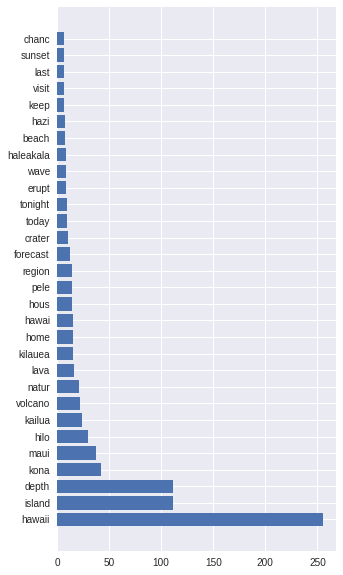

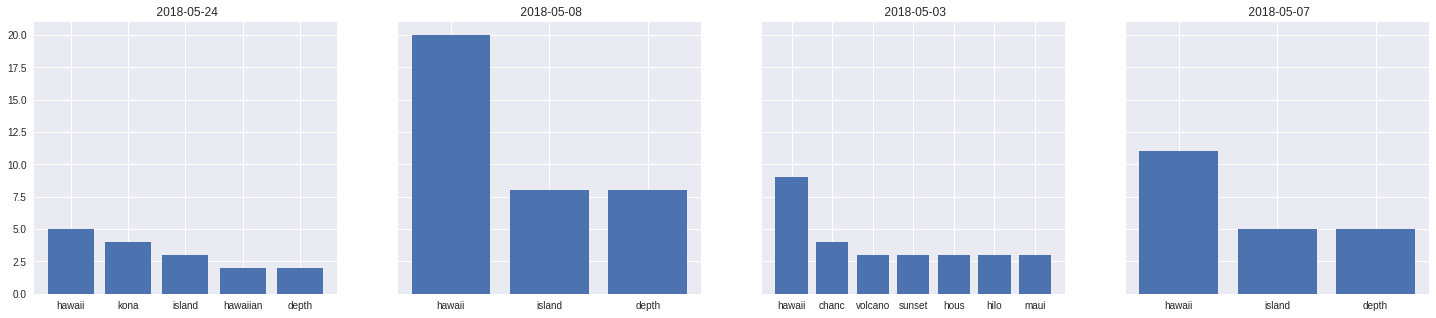

In [33]:
plot_words(
    frequency_all()
)

plot_words_perday(
    frequency_perday()
)
#print(remove_dots(remove_numbers("#Good am! 4 567 🤙🌋 @ !!Cen@ter ????///--__for Spiritual Living in H...")))


## Contabilizando emojis


In [34]:
alls
Counter(alls).most_common()

[('🌋', 48),
 ('🌊', 21),
 ('🤙', 18),
 ('🙏', 15),
 ('🌴', 15),
 ('✅', 15),
 ('🍹', 12),
 ('❤', 12),
 ('☀', 9),
 ('🌺', 9),
 ('🔥', 9),
 ('💦', 9),
 ('💙', 6),
 ('🦀', 6),
 ('👣', 6),
 ('📍', 6),
 ('🥥', 6),
 ('🐬', 6),
 ('🍋', 3),
 ('♋', 3),
 ('😱', 3),
 ('😓', 3),
 ('🚗', 3),
 ('😳', 3),
 ('🌟', 3),
 ('⛰', 3),
 ('⛅', 3),
 ('😙', 3),
 ('😔', 3),
 ('💃', 3),
 ('💜', 3),
 ('🏝', 3),
 ('🌞', 3),
 ('👍', 3),
 ('😊', 3),
 ('🏖', 3),
 ('🏄', 3),
 ('♀', 3),
 ('😂', 3),
 ('‼', 3),
 ('🌄', 3),
 ('🦐', 3),
 ('🐠', 3),
 ('🐟', 3),
 ('😍', 3),
 ('🌈', 3),
 ('🌹', 3),
 ('😎', 3),
 ('💯', 3),
 ('🙁', 3),
 ('🤖', 3),
 ('🍍', 3),
 ('✔', 3)]

## Traduzindo Texto dos Tweets

In [14]:
#https://py-googletrans.readthedocs.io/en/latest/

#Detect lang and traslate
from googletrans import Translator

data_lang = {}
translator = Translator()
text = ["hello filho da puta","muito orgulho, olha aí parceiro"]
s = translator.translate(text, dest = 'en')

for x in s:
    print(x.text)

hello motherfucker
very proud, look there, partner


In [35]:
import folium
from folium import plugins

hawaii = folium.Map(location = [19.643392, -155.369082], zoom_start = 7.5)
hawaii

lat = data['latitude']
long = data['longitude']

mapa = folium.Map(location=[19.433409, -155.287767],zoom_start=7.5)
 
for la,lo in zip(lat,long):
    folium.Marker([la, lo]).add_to(mapa)
mapa

In [36]:
coordenadas = []
mapa = folium.Map(location=[19.433409, -155.287767],tiles='Stamen Toner',zoom_start=7.5)

for la,lo in zip(lat,long):
    coordenadas.append([la,lo])
mapa.add_child(plugins.HeatMap(coordenadas))
mapa

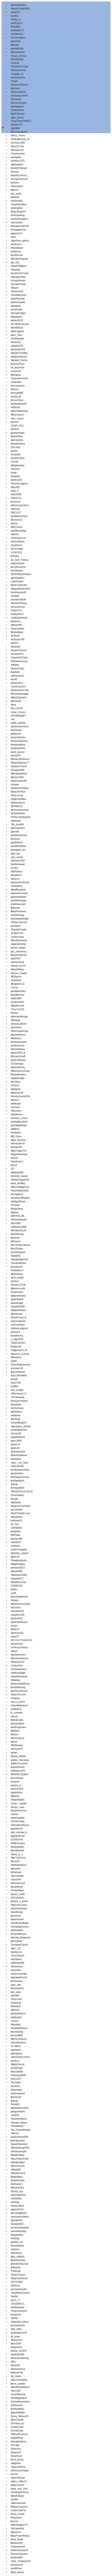

In [17]:
import cartopy.crs as ccrs 
import cartopy.feature as cfeature 

  
birddata = pd.read_csv("data_set.csv") 
bird_names = pd.unique(birddata.screen_name) 
  
proj = ccrs.Mercator()  
  
plt.figure(figsize=(100,10)) 
ax = plt.axes(projection=proj) 
ax.set_extent((-155, -145, 19, 30)) 
ax.add_feature(cfeature.LAND) 
ax.add_feature(cfeature.OCEAN) 
ax.add_feature(cfeature.COASTLINE) 
ax.add_feature(cfeature.BORDERS, linestyle=':') 
for name in bird_names: 
    ix = birddata['screen_name'] == name 
    x,y = birddata.longitude[ix], birddata.latitude[ix] 
    ax.plot(x,y,'.', transform=ccrs.Geodetic(), label=name) 
plt.legend(loc="upper left") 
plt.show() 
